In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
from scipy.optimize import curve_fit
import random
import os
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

## Cahn-Hilliard equation

$$\dfrac{\partial c}{\partial t} = D \nabla^2\mu$$
$$\mu = c^3 - c - \gamma\nabla^2 c$$

- $D$ = Diffusion coefficient
- $\sqrt{\gamma}$ = length of the transition regions between the domains

# Functions


In [41]:
def rk4(X, h, derivs, *args):
    '''
    Runge-kutta implementation
    '''
    f = derivs(X, *args)
    f1 = derivs(X + f * h/2, *args)
    f2 = derivs(X + f1 * h/2, *args)
    f3 = derivs(X + f2 * h, *args)
    f4 = X + h*(f + 2*f1 + 2*f2 + f3)/6
    return f4

def correct_overflow(X, limit=1):

    X[X > limit] = limit
    X[X < -limit] = -limit
    return None

def integrator(nsteps, dt, X0, derivs, *args):
    '''
    Iterates runge-kutta for nsteps of size dt starting from initial condition x0
    '''
    X = np.empty((nsteps + 1, N, N))
    X[0] = X0
    for i in range(nsteps):
        X[i+1] = rk4(X[i], dt, derivs, *args)
        correct_overflow(X[i+1])
    return X

def derivs(c, D, gamma):
    '''
    Accepts a 2D array of concentrations
    Calculates the time derivative of concentration using the Cahn-hilliard equation
    Returns a 2D array of the time derivative of concentrations
    '''
    del2_c = scipy.ndimage.laplace(c, mode='wrap')  # periodic boundary conditions
    mu = c**3 - c - gamma * del2_c
    dcdt = D * scipy.ndimage.laplace(mu, mode='wrap')
    return dcdt

def tweak(c0):
    '''
    Helper function.
    Due to the nature of randomness, we don't land exactly on avg concentration = phi.
    Restore the desired concentration by tweaking some array values.
    '''
    c_tweak = np.copy(c0)
    C0_off = np.sum(c_tweak) / N**2 - phi
    indices = np.argwhere(np.any((c0-C0_off) < 1, axis=1))
    c_tweak[indices] -= C0_off

    return c_tweak

def gen_initial_cond_normal(N, phi, width):
    '''
    Generates an NxN matrix of concentrations.
    phi = order parameter
    '''
    c0 = np.random.normal(loc=phi, scale=width, size=(N, N))
    c_tweak = tweak(c0)
    return c_tweak

def gen_initial_cond_uniform(N, phi, width):
    '''
    Generates an NxN matrix of concentrations.
    phi = order parameter
    '''
    c0 = np.random.uniform(phi - width/2, phi + width/2, size=(N, N))
    c_tweak = tweak(c0)
    return c_tweak

def guassian(x, mu, sigma):

    expo = -0.5 * ((x - mu) / sigma) ** 2
    coeff = sigma * np.sqrt(2 * np.pi)
    return np.exp(expo) / coeff 

# Set up initial condition

In [3]:
N = 100  # matrix size
phi = 0.0  # order parameter
width = 0.12  # Gaussian width

c0 = gen_initial_cond_normal(N, phi, width)
correct_overflow(c0)

print('Average initial concentration:', np.sum(c0) / N**2)
print('Range of concentrations: ({}, {})'.format(np.max(c0), np.min(c0)))

Average initial concentration: -9.325873406851314e-19
Range of concentrations: (0.4250148974070667, -0.43130475196826534)


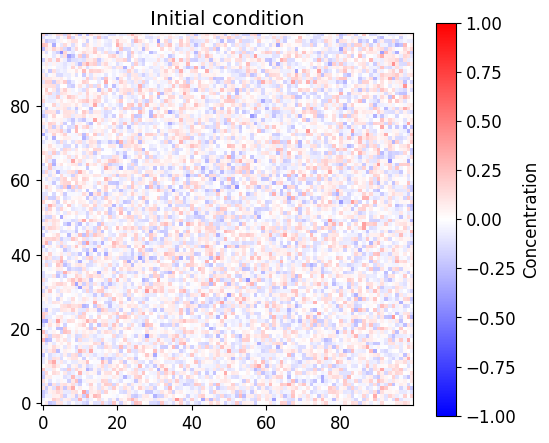

In [4]:
plt.figure(figsize=(6, 6))
plt.rc('font', size=12) 

plt.imshow(c0, cmap='bwr', origin='lower', aspect='equal')
plt.colorbar(label='Concentration', shrink=0.85)
plt.clim(-1, 1)
plt.title('Initial condition')

plt.show()

In [5]:
x_span = np.linspace(-1, 1, 1000)
model_distribution = guassian(x_span, phi, width)

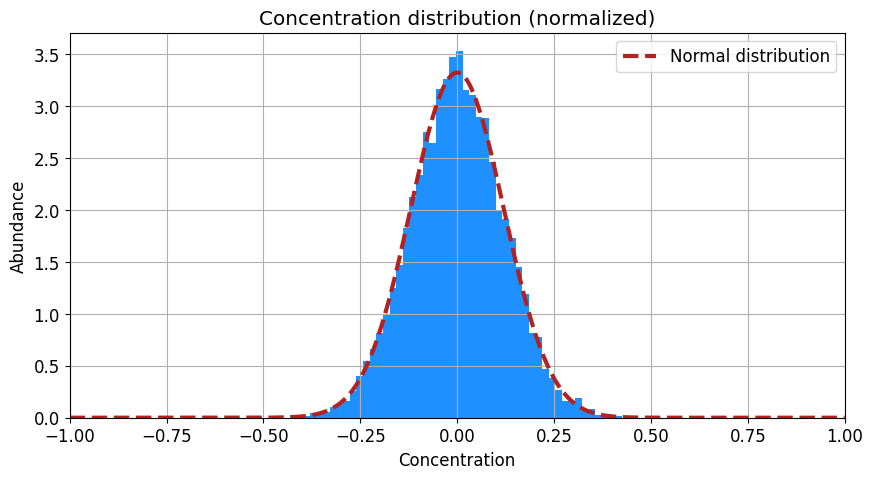

In [6]:
plt.figure(figsize=(10, 5))
plt.rc('font', size=12) 

plt.hist(c0.reshape(N**2,), bins=50, density=True, color='dodgerblue')
plt.plot(x_span, model_distribution, ls='--', lw=3, color='firebrick', label='Normal distribution')
plt.title('Concentration distribution (normalized)')
plt.ylabel('Abundance')
plt.xlabel('Concentration')
plt.xlim(-1, 1)
plt.legend()
plt.grid()

plt.show()

# Do the integration

In [52]:
# Choose integration parameters
dt = 0.006
nsteps = 6000

time_array = np.linspace(0, dt * nsteps, nsteps + 1)

# Choose Cahn-Hilliard equation parameters
D = 7.0
gamma = 0.8

In [53]:
# Iterate
c_series = integrator(nsteps, dt, c0, derivs, D, gamma)

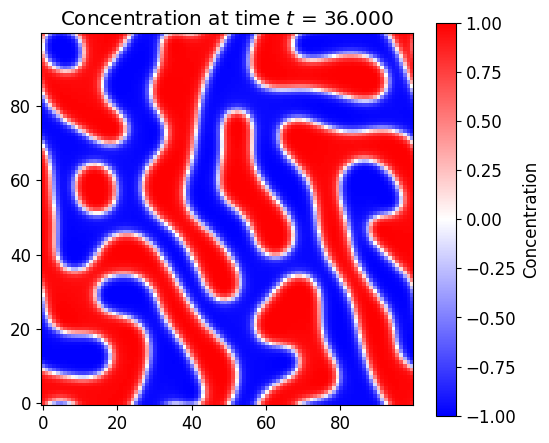

In [54]:
t_index = nsteps

plt.figure(figsize=(6, 6))
plt.rc('font', size=12) 

plt.imshow(c_series[t_index], cmap='bwr', origin='lower', aspect='equal')
plt.colorbar(label='Concentration', shrink=0.85)
plt.clim(-1, 1)
plt.title(r'Concentration at time $t$ = %.3f' % time_array[t_index])

plt.show()

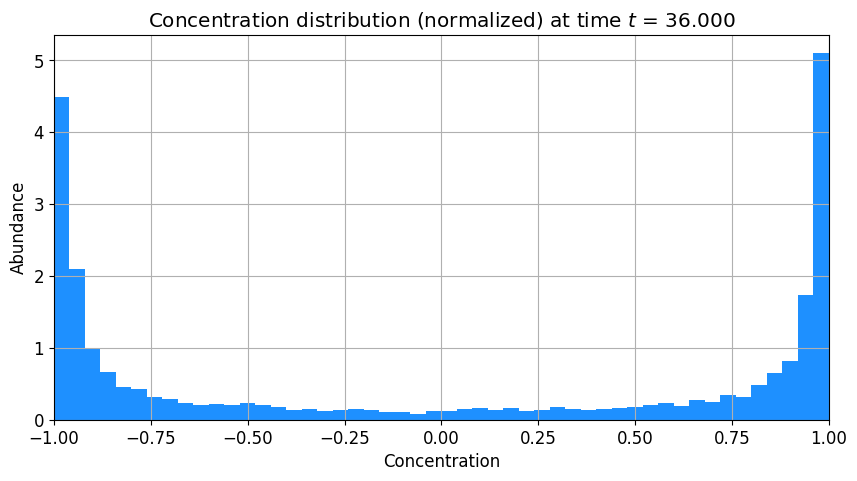

In [55]:
plt.figure(figsize=(10, 5))
plt.rc('font', size=12) 

plt.hist(c_series[t_index].reshape(N**2), bins=50, density=True, color='dodgerblue')
plt.title('Concentration distribution (normalized) at time $t$ = %.3f' % time_array[t_index])
plt.ylabel('Abundance')
plt.xlabel('Concentration')
plt.xlim(-1, 1)
plt.grid()

plt.show()

# Make videos

In [11]:
skip = 15

decomposition_filenames = []

decomposition_directory = 'decomposition_images/'
if not os.path.exists(decomposition_directory):
    os.mkdir(decomposition_directory)

n_zeros = len(str(nsteps+1))

for t_index in range(0, nsteps+1, skip):

    plt.figure(figsize=(6, 6))
    plt.imshow(c_series[t_index], cmap='bwr', origin='lower', aspect='equal')
    plt.clim(-1, 1)
    plt.yticks([])
    plt.xticks([])
    plt.title(r'$t$ = %.3f' % time_array[t_index])

    filename = decomposition_directory + 'decomposition_' + str(t_index).zfill(n_zeros) + '.png'
    plt.savefig(filename, bbox_inches='tight')
    decomposition_filenames.append(filename)
    
    plt.close()

In [12]:
# Create movie using all figures, then move them to the directory for figures

frames_per_second = 30
movie_name = 'decomposition_movie.mp4'

clip = ImageSequenceClip(decomposition_filenames, fps=frames_per_second)
clip.write_videofile(movie_name)

# The resulting mp4 file seems not to be readable by QuickTime player but works with VLC player.

Moviepy - Building video decomposition_movie.mp4.
Moviepy - Writing video decomposition_movie.mp4



Moviepy - Done !
Moviepy - video ready decomposition_movie.mp4


In [13]:
skip = 15

histogram_filenames = []

histogram_directory = 'distribution_figures/'
if not os.path.exists(histogram_directory):
    os.mkdir(histogram_directory)

n_zeros = len(str(nsteps+1))

counts_list = []
time_list = []

for t_index in range(0, nsteps+1, skip):

    counts, bins = np.histogram(c_series[t_index].reshape(N**2), bins=50, density=True)
    counts_list.append(counts)
    time_list.append(t_index)

m = np.max(counts_list)

for i, counts in enumerate(counts_list):
    
    plt.figure(figsize=(10, 5))
    plt.hist(bins[:-1], bins, weights=counts, color='dodgerblue')
    plt.title('$t$ = %.3f' % time_list[i])
    plt.ylabel('Abundance (normalized)')
    plt.xlabel('Concentration')
    plt.ylim(0, m * 1.1)
    plt.xlim(-1, 1)
    plt.grid()

    filename = histogram_directory + 'distribution_' + str(time_list[i]).zfill(n_zeros) + '.png'
    plt.savefig(filename, bbox_inches='tight')
    histogram_filenames.append(filename)
    
    plt.close()

In [14]:
# Create movie using all figures, then move them to the directory for figures

frames_per_second = 30
movie_name = 'distribution_movie.mp4'

clip = ImageSequenceClip(histogram_filenames, fps=frames_per_second)
clip.write_videofile(movie_name)

# The resulting mp4 file seems not to be readable by QuickTime player but works with VLC player.

Moviepy - Building video distribution_movie.mp4.
Moviepy - Writing video distribution_movie.mp4



Moviepy - Done !
Moviepy - video ready distribution_movie.mp4


# Fourier analysis

$$\lambda=\dfrac{2\pi}{k}$$

To find the characteristic wavelength of the spinodal pattern, we take the 2D fourier transform of the pattern and divide $2\pi$ by the radius of the ring that will come out of the fourier transform.

In [56]:
# Calculate Fourier transform of spinodal pattern
ft = np.fft.ifftshift(c_series)
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)
Fourier = np.fft.fft2(ft)

In [57]:
# k_range = np.fft.fftfreq(N) * 2 * np.pi
# k_range.sort()
ticks = np.arange(0, N, 10)

In [58]:
# Not working

# t_index = nsteps

# plt.figure(figsize=(6, 6))
# plt.rc('font', size=12) 

# plt.imshow(np.abs(ft[t_index]), cmap='inferno', origin='lower', aspect='equal')
# plt.title(r'Spinodal pattern in Fourier space at time $t$ = %.3f' % time_array[t_index])
# plt.colorbar(label='Resonance', shrink=0.8)

# plt.xlabel(r'$k_x$')
# plt.xticks(ticks=ticks, labels=np.round(2 * np.pi / k_range[::10], 1))

# plt.ylabel(r'$k_y$')
# plt.yticks(ticks=ticks, labels=np.round(k_range[::10], 1))
# plt.grid(color='gray')

# plt.show()

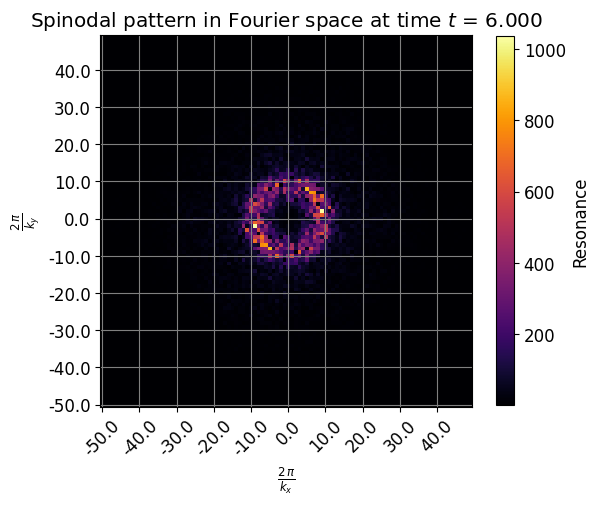

In [59]:
t_index = 1000

plt.figure(figsize=(6, 6))
plt.rc('font', size=12) 

plt.imshow(np.abs(ft[t_index]), cmap='inferno', origin='lower', aspect='equal')
plt.title(r'Spinodal pattern in Fourier space at time $t$ = %.3f' % time_array[t_index])
plt.colorbar(label='Resonance', shrink=0.8)

plt.xlabel(r'$\frac{2 \, \pi}{k_x}$')
plt.xticks(ticks=ticks, labels=ticks - N/2, rotation=45)

plt.ylabel(r'$\frac{2 \, \pi}{k_y}$')
plt.yticks(ticks=ticks, labels=ticks - N/2)

plt.grid(color='gray')

plt.show()

In [32]:
skip = 15

fourier_filenames = []

fourier_directory = 'Fourier_space_images/'
if not os.path.exists(fourier_directory):
    os.mkdir(fourier_directory)

n_zeros = len(str(nsteps+1))

for t_index in range(0, nsteps+1, skip):

    plt.figure(figsize=(6, 6))
    plt.imshow(np.abs(ft[t_index]), cmap='inferno', origin='lower', aspect='equal')
    plt.yticks([])
    plt.xticks([])
    plt.title(r'$t$ = %.3f' % time_array[t_index])
    plt.grid(color='gray')

    filename = fourier_directory + 'Fourier_space_' + str(t_index).zfill(n_zeros) + '.png'
    plt.savefig(filename, bbox_inches='tight')
    fourier_filenames.append(filename)
    
    plt.close()

In [20]:
# Create movie using all figures, then move them to the directory for figures

frames_per_second = 30
movie_name = 'Fourier_space_movie.mp4'

clip = ImageSequenceClip(fourier_filenames, fps=frames_per_second)
clip.write_videofile(movie_name)

# The resulting mp4 file seems not to be readable by QuickTime player but works with VLC player.

Moviepy - Building video Fourier_space_movie.mp4.
Moviepy - Writing video Fourier_space_movie.mp4



Moviepy - Done !
Moviepy - video ready Fourier_space_movie.mp4


In [60]:
frame = 1000

def free_gaussian(x, a, b, c, d):
  return a * np.exp(-(x-b) ** 2 / (2 * c ** 2)) + d

# Get array of radii
x, y = np.meshgrid(np.arange(N), np.arange(N))
x0 = int(N/2)
y0 = int(N/2)
R = np.sqrt((x - x0) ** 2 + (y - y0) ** 2)
r = np.linspace(1, x0, num=x0)
r_plotting = np.linspace(1, x0, num=500)

fourier = np.abs(ft[frame])
f = lambda r : fourier[(R >= r-0.5) & (R < r+0.5)].mean()
intensity = np.vectorize(f)(r)

# Fit gaussian to radial intensity of 2D FT
p0 = [194.22105802, 14.96042073, 5.09829981, 26.45927884]
#p0 = [301.4009438, 8.98821741, 3.22742278, 9.79648574]
popt, pcov = curve_fit(free_gaussian, r, intensity,p0)
ring_fit = popt[1]
char_lambda = N / ring_fit

In [61]:
print('In real space, the characteristic wavelength is', char_lambda)

In real space, the characteristic wavelength is 11.19944908207721


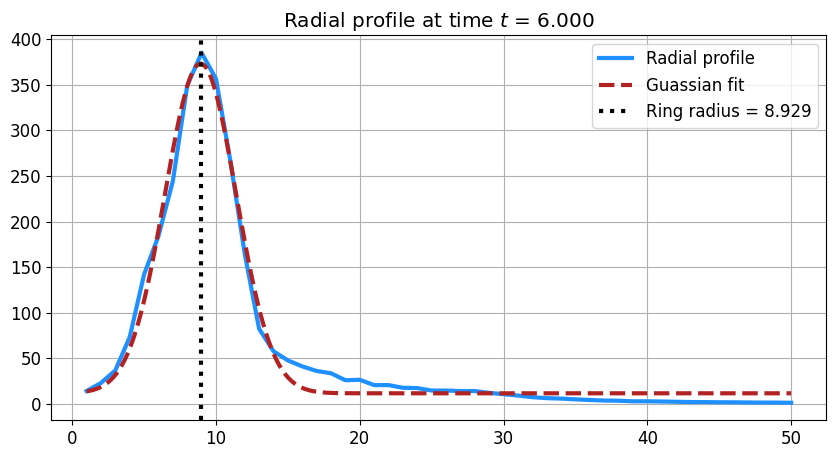

In [62]:
t_index = frame

plt.figure(figsize=(10, 5))
plt.rc('font', size=12) 

plt.plot(r, intensity, color='dodgerblue', lw=3, label='Radial profile')
plt.plot(r_plotting, free_gaussian(r_plotting, *popt), color='firebrick', ls='--', lw=3, label='Guassian fit')
plt.axvline(ring_fit, color='black', ls= ':', lw=3, label='Ring radius = %.3f' % ring_fit)
plt.title(r'Radial profile at time $t$ = %.3f' % time_array[t_index])
plt.legend()
plt.grid()

plt.show()

In [63]:
# Below this needs more work

In [64]:
def track_char_lambda(c_series, nsteps):
    
    # Get fourier transform
    ft = np.fft.ifftshift(c_series)
    ft = np.fft.fft2(ft)
    ft = np.fft.fftshift(ft)
    
    # Get array of radii
    x, y = np.meshgrid(np.arange(N), np.arange(N))
    x0 = int(N / 2)
    y0 = int(N / 2)
    R = np.sqrt((x-x0) ** 2 + (y-y0) ** 2)
    r = np.linspace(1, x0, num=x0)
    
    # Get char_lambda for all frames starting from start
    start = 10
    frames = np.arange(start, nsteps)
    char_lambda = np.empty(nsteps - start)
    
    for i in range(nsteps - start):
        frame = frames[i]
        fourier = np.abs(ft[frame])
        f = lambda r : fourier[(R >= r-0.5) & (R < r+0.5)].mean()
        intensity = np.vectorize(f)(r)
        
        
        p0 = [194.22105802, 14.96042073, 5.09829981, 26.45927884]
        #p0 = [301.4009438, 8.98821741, 3.22742278, 9.79648574]
        popt, pcov = curve_fit(free_gaussian, r, intensity, p0=p0)
        ring_fit = popt[1]
        char_lambda[i] = N/ring_fit

    return frames * dt, char_lambda

def linear(x, a, b):
    return a * x + b

def cube_root(x, a, c):
    return a * x ** (1/3) + c

In [66]:
# Changing gamma (Cahn-Hilliard equation parameter) for three more simulations

gamma1 = 0.2
c_series1 = integrator(nsteps, dt, c0, derivs, D, gamma1)
time1, char_lambda1 = track_char_lambda(c_series1, nsteps)

gamma2 = 0.4
c_series2 = integrator(nsteps, dt, c0, derivs, D, gamma2)
time2, char_lambda2 = track_char_lambda(c_series2, nsteps)

gamma3 = 0.6
c_series3 = integrator(nsteps, dt, c0, derivs, D, gamma3)
time3, char_lambda3 = track_char_lambda(c_series3, nsteps)

# Simulation from above
time4, char_lambda4 = track_char_lambda(c_series, nsteps)

In [68]:
popt1, pcov1 = curve_fit(cube_root, time1[10:], char_lambda1[10:])
popt2, pcov2 = curve_fit(cube_root, time2[200:], char_lambda2[200:])
popt3, pcov3 = curve_fit(cube_root, time3[250:], char_lambda3[250:])
popt4, pcov4 = curve_fit(cube_root, time4[300:], char_lambda4[300:])

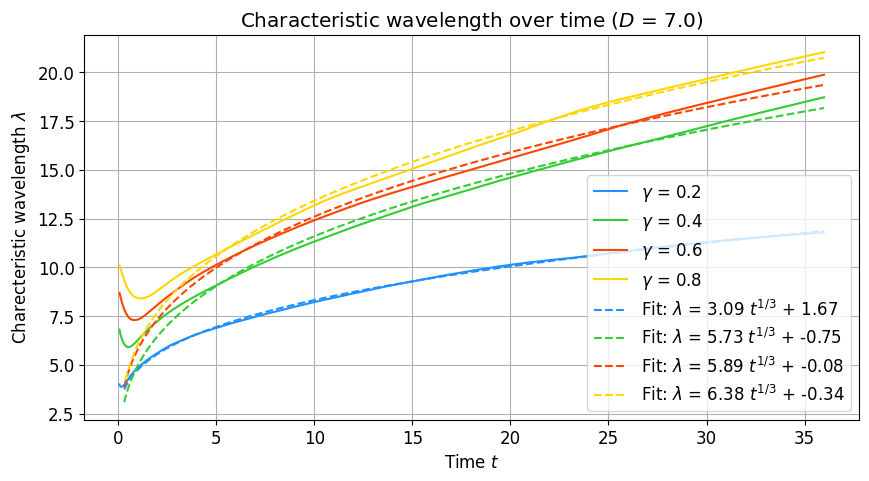

In [72]:
clrs = ['dodgerblue', 'limegreen', 'orangered', 'gold']

plt.figure(figsize=(10, 5))
plt.rc('font', size=12) 

plt.plot(time1, char_lambda1, color=clrs[0], lw=1.5, label=r'$\gamma$ = %.1f' % gamma1)
plt.plot(time2, char_lambda2, color=clrs[1], lw=1.5, label=r'$\gamma$ = %.1f' % gamma2)
plt.plot(time3, char_lambda3, color=clrs[2], lw=1.5, label=r'$\gamma$ = %.1f' % gamma3)
plt.plot(time4, char_lambda4, color=clrs[3], lw=1.5, label=r'$\gamma$ = %.1f' % gamma)

plt.plot(time1[40:], cube_root(time1[40:], *popt1),
         color=clrs[0], ls='--', lw=1.5, label=r'Fit: $\lambda$ = %.2f $t^{1/3}$ + %.2f' % tuple(popt1))
plt.plot(time2[40:], cube_root(time2[40:], *popt2),
         color=clrs[1], ls='--', lw=1.5, label=r'Fit: $\lambda$ = %.2f $t^{1/3}$ + %.2f' % tuple(popt2))
plt.plot(time3[40:], cube_root(time3[40:], *popt3),
         color=clrs[2], ls='--', lw=1.5, label=r'Fit: $\lambda$ = %.2f $t^{1/3}$ + %.2f' % tuple(popt3))
plt.plot(time4[50:], cube_root(time4[50:], *popt4),
         color=clrs[3], ls='--', lw=1.5, label=r'Fit: $\lambda$ = %.2f $t^{1/3}$ + %.2f' % tuple(popt4))

plt.title(r'Characteristic wavelength over time ($D$ = %.1f)' % D)
plt.xlabel(r'Time $t$')
plt.ylabel(r'Charecteristic wavelength $\lambda$')

plt.grid()
plt.legend()

plt.show()

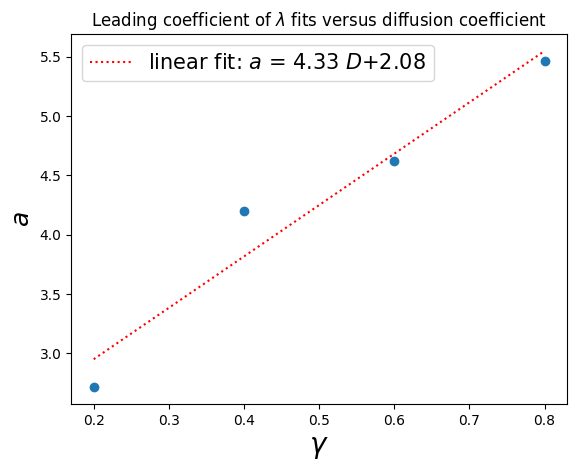

In [ ]:
gammas = np.array([0.2,0.4,0.6,0.8])
lam_coeff = np.array([popt1[0],popt2[0],popt3[0],popt4[0]])
popt5, pcov5 = curve_fit(xlinear, Gamm, lam_coeff)

plt.title('Leading coefficient of $\lambda$ fits versus diffusion coefficient')
plt.xlabel('$\gamma$',fontsize=20)
plt.ylabel('$a$',fontsize=18)
plt.plot(Gamm, xlinear(Gamm, *popt5),'r:',label='linear fit: $a$ = %.2f $D$+%.2f'%tuple(popt5))
plt.scatter(Gamm,lam_coeff)
plt.legend(fontsize=15)

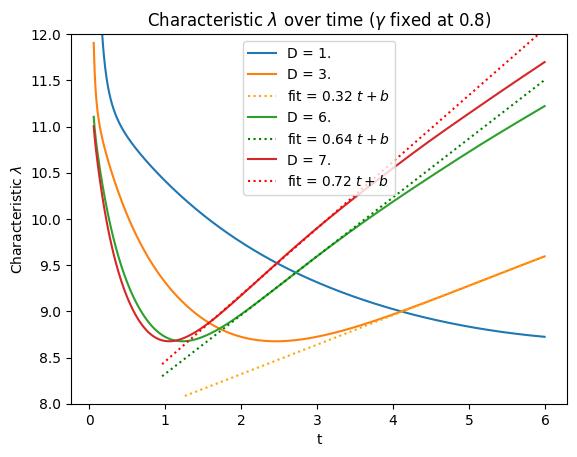

In [ ]:
#popt1, pcov1 = curve_fit(linear, time1[200:], char_lambda1[200:])
#slope1 = popt1[0]
popt2, pcov2 = curve_fit(linear, time2[800:], char_lambda2[800:])
slope2 = popt2[0]
popt3, pcov3 = curve_fit(linear, time3[380:510], char_lambda3[380:510])
slope3 = popt3[0]
popt4, pcov4 = curve_fit(linear, time4[300:550], char_lambda4[300:550])
slope4 = popt4[0]


plt.title('Characteristic $\lambda$ over time ($\gamma$ fixed at 0.8)')
plt.xlabel('t')
plt.ylabel('Characteristic $\lambda$')
plt.plot(time1,char_lambda1, label='D = 1.')
#plt.plot(time1[10:], linear(time1[10:], *popt1),'b:',label='fit = %.2f $t+b$'%slope1)
plt.plot(time2,char_lambda2, label='D = 3.')
plt.plot(time2[200:], linear(time2[200:], *popt2),color='orange', linestyle='dotted',label='fit = %.2f $t+b$'%slope2)
plt.plot(time3,char_lambda3, label='D = 6.')
plt.plot(time3[150:], linear(time3[150:], *popt3),'g:', label='fit = %.2f $t+b$'%slope3)
plt.plot(time4,char_lambda4, label='D = 7.')
plt.plot(time4[150:], linear(time4[150:], *popt4),'r:',label='fit = %.2f $t+b$'%slope4)
plt.ylim(8,12)

plt.legend()

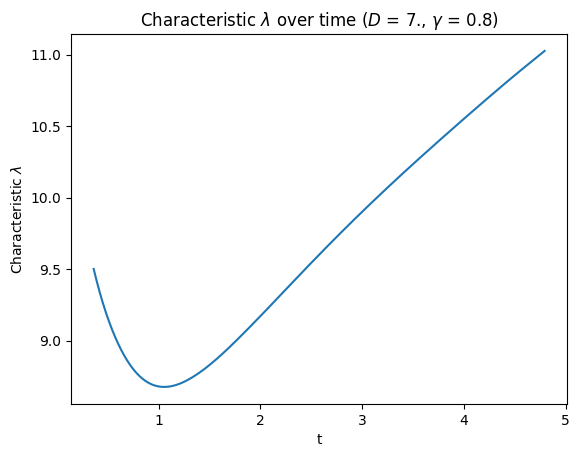

In [ ]:
time1, char_lambda1 = Track_char_lambda(ct1,nsteps1)
plt.title('Characteristic $\lambda$ over time ($D$ = 7., $\gamma$ = 0.8)')
plt.xlabel('t')
plt.ylabel('Characteristic $\lambda$')
plt.plot(time1,char_lambda1, label='$\gamma$ = 0.8')
